In [1]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
def f(X):
    y = 10*X[:,0] + 0.5*np.sin(2*4*X[:,0]*np.pi)
    y -= 10*X[:,1] + np.cos(2*4*X[:,1]*np.pi)
    y += np.random.randn(X.shape[0])
    return y

def generate_X(N):
    X1 = np.linspace(0, 1, N)
    X2 = np.linspace(0, 1, N)
    np.random.seed(1)
    np.random.shuffle(X2)
    X = np.array([X1, X2]).T
    return X

def fit_model(N, constr):
    X = generate_X(N)
    y = f(X)
    params = {
        "objective": "reg:squarederror",
        "tree_method": "exact",
        "max_depth": 4,
        "learning_rate": 0.5,
        "monotone_constraints": constr
    }
    dtrain = xgb.DMatrix(X, label=y)
    model = xgb.train(params, dtrain, num_boost_round = 10, evals=[(dtrain,"train")])
    yhat = model.predict(dtrain)
    return X, y, yhat, model

def plot_model(model, N):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,3))
    
    X = np.array([np.linspace(0, 1, N), [0.5]*N]).T
    y, yhat = f(X), model.predict(xgb.DMatrix(X))
    
    ax0.plot(X[:,0], y, marker=".", linewidth=0)
    ax0.plot(X[:,0], yhat, "x", markersize=8)
    
    X = np.array([[0.5] * N, np.linspace(0, 1, N)]).T
    y, yhat = f(X), model.predict(xgb.DMatrix(X))
    
    ax1.plot(X[:,1], y, marker=".", linewidth=0)
    ax1.plot(X[:,1], yhat, "x", markersize=8)
    
    plt.show()

[0]	train-rmse:2.47805
[1]	train-rmse:1.57964
[2]	train-rmse:1.12437
[3]	train-rmse:0.889192
[4]	train-rmse:0.770176
[5]	train-rmse:0.689008
[6]	train-rmse:0.654874
[7]	train-rmse:0.617198
[8]	train-rmse:0.582826
[9]	train-rmse:0.558225


<IPython.core.display.Javascript object>


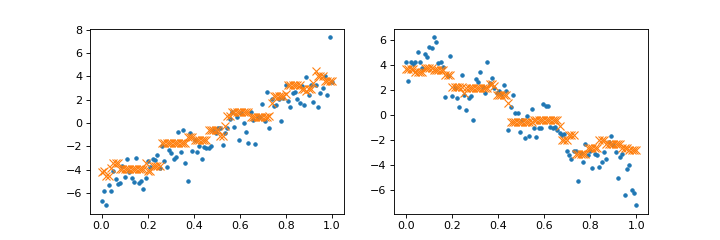

In [3]:
X, y, yhat, model = fit_model(200, "(0,0)")
plot_model(model, 100)

[0]	train-rmse:2.47716
[1]	train-rmse:1.58163
[2]	train-rmse:1.11962
[3]	train-rmse:0.912489
[4]	train-rmse:0.803083
[5]	train-rmse:0.752019
[6]	train-rmse:0.721353
[7]	train-rmse:0.671069
[8]	train-rmse:0.638452
[9]	train-rmse:0.618215


<IPython.core.display.Javascript object>


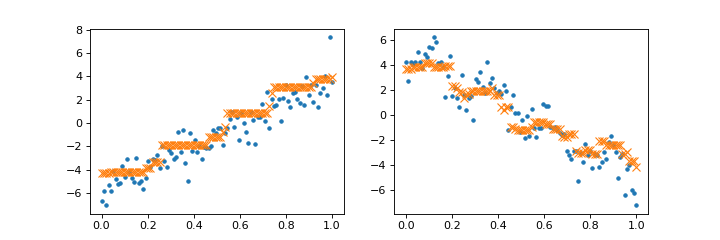

In [4]:
X, y, yhat, model = fit_model(200, "(1,0)")
plot_model(model, 100)

[0]	train-rmse:2.58261
[1]	train-rmse:1.61464
[2]	train-rmse:1.14546
[3]	train-rmse:0.929777
[4]	train-rmse:0.829059
[5]	train-rmse:0.767323
[6]	train-rmse:0.736666
[7]	train-rmse:0.715805
[8]	train-rmse:0.683732
[9]	train-rmse:0.662266


<IPython.core.display.Javascript object>


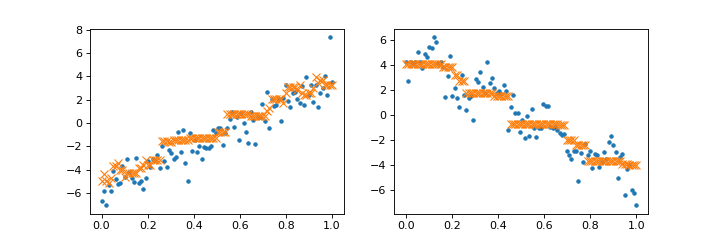

In [9]:
X, y, yhat, model = fit_model(200, "(0,-1)")
plot_model(model, 100)

[0]	train-rmse:2.5826
[1]	train-rmse:1.66708
[2]	train-rmse:1.22725
[3]	train-rmse:1.00489
[4]	train-rmse:0.897734
[5]	train-rmse:0.833375
[6]	train-rmse:0.80842
[7]	train-rmse:0.796715
[8]	train-rmse:0.790734
[9]	train-rmse:0.787054


<IPython.core.display.Javascript object>


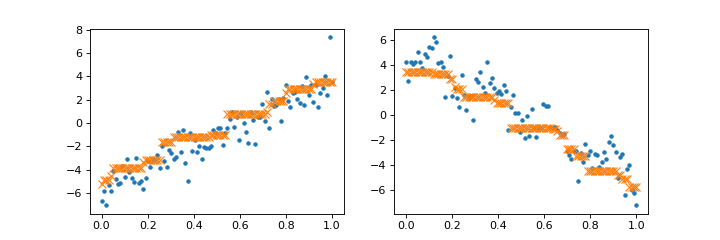

In [6]:
X, y, yhat, model = fit_model(200, "(1,-1)")
plot_model(model, 100)

# Verification

In [11]:
from treeck import SplitTree
from treeck.xgb import addtree_from_xgb_model
from treeck.verifier import Verifier, not_in_domain_constraint
from treeck.distributed import DistributedVerifier
from treeck.z3backend import Z3Backend as Backend

from dask.distributed import Client

rmse train 0.0468
rmse model difference 1.954e-08


<IPython.core.display.Javascript object>


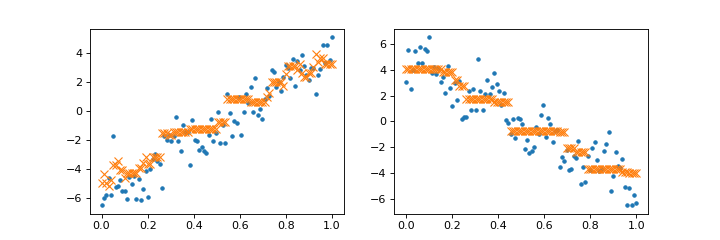

In [12]:
at = addtree_from_xgb_model(2, model)
sqerr = sum((y - model.predict(xgb.DMatrix(X)))**2)
sqcorr = sum((model.predict(xgb.DMatrix(X)) - at.predict(X))**2)
print(f"rmse train {np.sqrt(sqerr)/len(X):.4f}")
print(f"rmse model difference {np.sqrt(sqcorr)/len(X):.4g}")
plot_model(model, 100)

In [14]:
def vfactory(at, leaf):
    v = Verifier(at, leaf, Backend(), num_instances=2)
    v.add_constraint(v.fvar(instance=0) > v.fvar(instance=1))
    v.add_constraint(v.xvar(0, instance=0) < v.xvar(0, instance=1))
    v.add_constraint(v.xvar(1, instance=0) == v.xvar(1, instance=1))
    return v

#with Client("tcp://localhost:30333") as client:
#    #client.restart()
#    st = SplitTree(at, {})
#    dv = DistributedVerifier(client, st, vfactory,
#            check_paths = False,
#            stop_when_sat = False)
#
#    dv.check()

X11, X12, X2 = [], [], []
f1, f2 = [], []

st = SplitTree(at, {})
v = vfactory(at, st.get_leaf(0))
v.add_all_trees(instance=0); v.add_all_trees(instance=1)
while v.check().is_sat() and len(X11) < 50:
    m = v.model()
    fam = v.model_family(m)
    v.add_constraint(not_in_domain_constraint(v, fam[0]))
    v.add_constraint(not_in_domain_constraint(v, fam[1]))

    #print("sat:", m[0]["xs"], "=>", m[0]["f"])
    #print("    ", m[1]["xs"], "=>", m[1]["f"])
    #print(m[0]["f"], m[1]["f"], m[0]["f"]-m[1]["f"])
    #print("    ", fam)
    
    X11.append(m[0]["xs"][0])
    X12.append(m[1]["xs"][0])
    X2.append(m[0]["xs"][1])
    f1.append(m[0]["f"])
    f2.append(m[1]["f"])
    
print(len(X11))

50


<IPython.core.display.Javascript object>


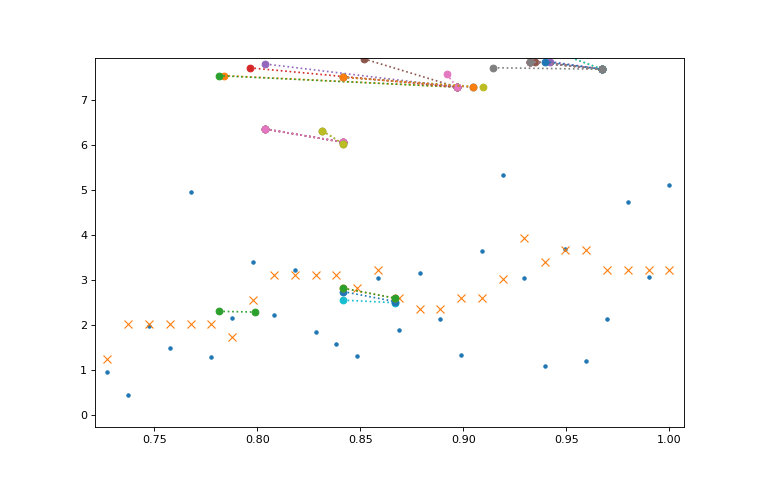

0.2585694232464464
6.900735938231151e-07
[0.01625516 0.29301801 0.29301801 0.29301801 0.29301801 0.29301801
 0.29301801 0.05686626 0.22035876 0.22035876]
[0.01625516 0.29301801 0.29301801 0.29301801 0.29301801 0.29301801
 0.29301801 0.05686626 0.22035876 0.22035876]


In [15]:
fig, ax0 = plt.subplots(figsize=(9.5,6))
aaa = np.array([np.linspace(0, 1, 100), [0.5]*100]).T
bbb, ccc = f(aaa), model.predict(xgb.DMatrix(aaa))
ax0.plot(aaa[:,0], bbb, marker=".", linewidth=0)
ax0.plot(aaa[:,0], ccc, "x", markersize=8)

if len(X11) > 0:
    ym1 = model.predict(xgb.DMatrix(np.array([X11, X2]).T))
    ym2 = model.predict(xgb.DMatrix(np.array([X12, X2]).T))
    ya1 = np.array(at.predict(list(zip(X11, X2))))
    ya2 = np.array(at.predict(list(zip(X12, X2))))
    print(max(abs(ym1-ya1)))
    print(max(abs(ym2-ya2)))
    print((ya1-ya2)[:10])
    print((np.array(f1)-np.array(f2))[:10])
    for x1,x2,y1,y2 in zip(X11, X12, ya1, ya2):
        ax0.plot([x1, x2], [y1, y2], ":o")